## Introduction:
In this notebook I train and tune a logistic regression model, which I will later use to label the sentiment of the Steelers tweets I scraped. In pretrials logistic regression outperformed several pretained models from the nltk library (e.g. TextBlob, VADER), multinomial naive bayes, the linear support vector classifier, and the random forest classifier in terms of overall performance (accuracy, precision, and f1 score). The data I scraped from twitter data is unlabeled. So, to train, evaluate, and tune the model I use a previously labeled data set of tweets from kaggle (https://www.kaggle.com/kazanova/sentiment140/version/2), supplmented with some manually labelled Steelers tweets (so the algorithm can gain some familiarity with football tweets). The dataset from kaggle is fairly clean and comtains binary sentiment labels (0= negative, 4=positive) of over a million tweets. I apply various preprocessing steps and use a balanced proportion of positive and negative tweets to train the model. However, because the sample of Steelers tweets that I used to supplement the data from tweitter was unbalanced in a 3:2 ratio (3 negative to 2 positive) I use an unbalanced validation and test set to tune and ultimately evaluate the model. In general, I strived to balance the model's accuracy, precision, and recall across both the majority (negative) and minority (positive) classes. My model achieved a .78 accuracy score, .81 and .73 precision scores on the positive and negative classes (respectively), and a macro f1 score of .77.    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import pickle
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.stem.snowball import SnowballStemmer
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

## 1. Download and Preprocess Training, Validation, and Test Data

In [2]:
#Read in data
df=pd.read_csv('twitsentdata.csv')
#Rename columns
df = df.rename(columns={'0': 'sentiment', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "text"})
#Change labels
df['sentiment'] = df.sentiment.apply(lambda x : 1 if x == 4 else 0)
#Select relevant columns
df = df.loc[:,['sentiment', 'text']]
#Drop duplicates
df.drop_duplicates(inplace=True)

In [3]:
#Define a modified text cleaner that additionally stems the tweets and removes stop words
def text_cleaner(text):
       
    #remove links 
    text = re.sub('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', "", text)
    
    #remove words with brackets
    text = re.sub('\[.*?\]',"", text)
    
    #remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    
    #remove hashtags and personal tags
    text = re.sub("(#|@)[A-Za-z0-9_]+","", text)

    #remove any extra spaces at beginning or end
    text= text.strip() 
    
    #remove all non-alphanumeric characters
    text= re.sub('[\W_]', ' ', text)
    
    #remove stop words
    stop_words = set(en_stop)
    tokens = word_tokenize(text)
    tokenized = [w for w in tokens if not w in stop_words]
    text = ' '.join(tokenized)
    
    #remove unhelpful words
    unhelpful_words = ['like', 'day', 'time', 'quot', 'day', 'feel', 'today', 'got']
    for word in unhelpful_words:
        text = text.replace(word, '')
    
    #apply stemmer
    s_stemmer = SnowballStemmer(language='english')
    stems=[]
    for word in text.split():
        stm= s_stemmer.stem(word)
        stems.append(stm)
        
        if len(stems) > 2:
            text = ' '.join(stems)
    
    #shorten double spaces
    while '  ' in text:
        text= text.replace('  ',' ')
    
    return text


In [4]:
#Define a function with our evaluation metrics
def eval_func(y_test, preds):
       
    #Print confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    
    #Print classification report
    print(classification_report(y_test, preds))     

In [5]:
#Manually create balanced train and imbalanced validation and test data

#Divide the df into positive and negative
pos = df[df['sentiment']==1]
pos=pos.sample(frac=1, random_state=0).reset_index()
neg = df[df['sentiment']==0]
neg=neg.sample(frac=1, random_state=0).reset_index()

#Allot portions of positive and negative tweets for training, validation, and testing 
train_pos=pos.iloc[0:225000]
train_neg=neg.iloc[0:225000]

valid_pos = pos.iloc[225000:229000]
valid_neg = neg.iloc[225000:231000]

test_pos= pos.iloc[229000:231000]
test_neg= neg.iloc[231000:234000]

#Add some manually labelled tweets from the Steelers game to the data for the machine to learn
df = pd.read_pickle("game_df_clean.pkl")
df=df.sample(100, random_state=1).reset_index()

Steelers_train= df.iloc[0:50]
Steelers_valid=df.iloc[50:75]
Steelers_test=df.iloc[75:100]
Steelers_train.drop(16, axis=0, inplace=True)

train_labels=[0,0,1, 0,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,
            1,0,1,0,0,0,0,0,1]
Steelers_train.loc[:,'sentiment']=train_labels

valid_labels=[0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1]
Steelers_valid.loc[:,'sentiment']=valid_labels

test_labels=[1,1,0,1,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1]
Steelers_test.loc[:,'sentiment'] = test_labels

Steelers_train = Steelers_train.loc[:, ['sentiment', 'original_text']]
Steelers_valid = Steelers_valid.loc[:, ['sentiment', 'original_text']]
Steelers_test = Steelers_test.loc[:, ['sentiment', 'original_text']]

Steelers_train.columns=['sentiment', 'text']
Steelers_valid.columns=['sentiment', 'text']
Steelers_test.columns=['sentiment', 'text']

#Combine to form training, validation, and test sets
train_combined=pd.concat([train_pos, train_neg, Steelers_train], ignore_index=True)
train_combined=train_combined.sample(frac=1, random_state=0)

valid_combined = pd.concat([valid_pos, valid_neg, Steelers_valid], ignore_index=True)
valid_combined= valid_combined.sample(frac=1, random_state=0)

test_combined = pd.concat([test_pos, test_neg, Steelers_test], ignore_index=True)
test_combined=test_combined.sample(frac=1, random_state=0)

#Clean the datasets and filter out rows with empty text
train_combined['clean_text']=train_combined.text.apply(lambda x: text_cleaner(x))
valid_combined['clean_text']=valid_combined.text.apply(lambda x: text_cleaner(x))
test_combined['clean_text']=test_combined.text.apply(lambda x: text_cleaner(x))
train_combined = train_combined[train_combined['clean_text']!='']
valid_combined = valid_combined[valid_combined['clean_text']!='']
test_combined = test_combined[test_combined['clean_text']!='']

#Make the training, validation, and testing features and labels
X_train = train_combined['clean_text']
y_train = train_combined['sentiment']
X_valid = valid_combined['clean_text']
y_valid = valid_combined['sentiment']
X_test = test_combined['clean_text']
y_test = test_combined['sentiment']

#Apply tfidf vectorizer to the features 
vectorizer=TfidfVectorizer(lowercase=True,
                           ngram_range= (1,3),
                           stop_words= 'english',
                           max_df=.85,
                           min_df=10,
                           norm='l2',
                           smooth_idf=True,
                           use_idf=True)

vectorizer.fit(X_train)
pickle.dump(vectorizer, open('tfidf_vectorizer.sav', 'wb'))
X_train_tfidf = vectorizer.transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)


C:\Users\karbo\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\karbo\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## 2. Training and Tuning the Model

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      5983
           1       0.00      0.00      0.00      3983

    accuracy                           0.60      9966
   macro avg       0.30      0.50      0.38      9966
weighted avg       0.36      0.60      0.45      9966



C:\Users\karbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


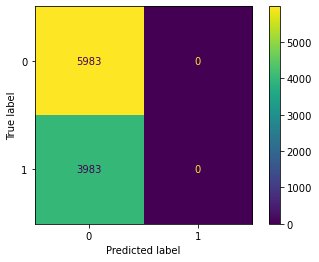

In [6]:
#Baseline Model: Predicting the majority class 
baseline_shape = y_valid.shape
baseline_preds = np.zeros(baseline_shape)
eval_func(y_valid, baseline_preds)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      5983
           1       0.68      0.78      0.73      3983

    accuracy                           0.77      9966
   macro avg       0.76      0.77      0.76      9966
weighted avg       0.78      0.77      0.77      9966



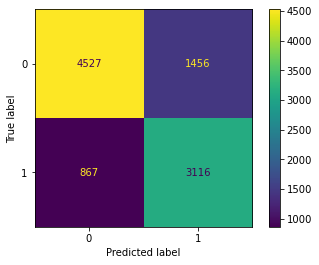

In [7]:
#Basic Logistic Regression Model
log = LogisticRegression(random_state=0, 
                         max_iter=1000, 
                         tol=.01)
log.fit(X_train_tfidf, y_train)
log_preds= log.predict(X_valid_tfidf)
eval_func(y_valid, log_preds)

In [8]:
#Tuning the model using GridSearchCV
model = LogisticRegression(random_state=0)
param = {
    'C': [1,1.1,1.2,1.3,1.4,1.5,1.6],
    'class_weight' :[None, 'balanced'],
    'max_iter':[1000],
    'solver':['liblinear','sag', 'saga', 'lbfgs'],
    'tol':[.01]
}

search = GridSearchCV(model, param, n_jobs=4, cv=10)
tuned_log = search.fit(X_train_tfidf,y_train)
print(f'Resulting accuracy score: {tuned_log.score(X_valid_tfidf, y_valid)}')
print(f'Resulting best paramters:{tuned_log.best_params_}')

Resulting accuracy score: 0.7667068031306442
Resulting best paramters:{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear', 'tol': 0.01}


In [9]:
#Honing in on the optimal decision threshold
tuned_log=LogisticRegression(random_state=0,
                             C=1, 
                             class_weight='balanced', 
                             max_iter=1000, 
                             solver='liblinear', 
                             tol=.01)
tuned_log.fit(X_train_tfidf, y_train)
pred_proba_df = pd.DataFrame(tuned_log.predict_proba(X_valid_tfidf))
threshold_list = [.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_valid_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    valid_accuracy = accuracy_score(y_valid.to_numpy().reshape(y_valid.to_numpy().size,1),
                                           y_valid_pred.iloc[:,1].to_numpy().reshape(y_valid_pred.iloc[:,1].to_numpy().size,1))
    print('Accuracy score is {}'.format(valid_accuracy))

    print(confusion_matrix(y_valid.to_numpy().reshape(y_valid.to_numpy().size,1),
                           y_valid_pred.iloc[:,1].to_numpy().reshape(y_valid_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Accuracy score is 0.47902869757174393
[[ 819 5164]
 [  28 3955]]

******** For i = 0.1 ******
Accuracy score is 0.551475015051174
[[1576 4407]
 [  63 3920]]

******** For i = 0.15 ******
Accuracy score is 0.5976319486253261
[[2095 3888]
 [ 122 3861]]

******** For i = 0.2 ******
Accuracy score is 0.6362632952036925
[[2561 3422]
 [ 203 3780]]

******** For i = 0.25 ******
Accuracy score is 0.6689745133453743
[[2964 3019]
 [ 280 3703]]

******** For i = 0.3 ******
Accuracy score is 0.6965683323299218
[[3334 2649]
 [ 375 3608]]

******** For i = 0.35 ******
Accuracy score is 0.7224563515954244
[[3678 2305]
 [ 461 3522]]

******** For i = 0.4 ******
Accuracy score is 0.7433273128637367
[[3991 1992]
 [ 566 3417]]

******** For i = 0.45 ******
Accuracy score is 0.7569737106160948
[[4265 1718]
 [ 704 3279]]

******** For i = 0.5 ******
Accuracy score is 0.7667068031306442
[[4525 1458]
 [ 867 3116]]

******** For i = 0.55 ******
Accuracy score is 0.775336142885811

In [10]:
#Further honing in on the optimal decision threshold 
pred_proba_df = pd.DataFrame(tuned_log.predict_proba(X_valid_tfidf))
threshold_list = [.55,.56,.57,.58,.59,.6, .61,.62,.63,.64,.65]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_valid_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    valid_accuracy = accuracy_score(y_valid.to_numpy().reshape(y_valid.to_numpy().size,1),
                                           y_valid_pred.iloc[:,1].to_numpy().reshape(y_valid_pred.iloc[:,1].to_numpy().size,1))
    print('Accuracy score is {}'.format(valid_accuracy))

    print(confusion_matrix(y_valid.to_numpy().reshape(y_valid.to_numpy().size,1),
                           y_valid_pred.iloc[:,1].to_numpy().reshape(y_valid_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.55 ******
Accuracy score is 0.7753361428858118
[[4798 1185]
 [1054 2929]]

******** For i = 0.56 ******
Accuracy score is 0.7753361428858118
[[4844 1139]
 [1100 2883]]

******** For i = 0.57 ******
Accuracy score is 0.7789484246437889
[[4975 1008]
 [1195 2788]]

******** For i = 0.58 ******
Accuracy score is 0.7783463776841261
[[5012  971]
 [1238 2745]]

******** For i = 0.59 ******
Accuracy score is 0.7765402368051375
[[5051  932]
 [1295 2688]]

******** For i = 0.6 ******
Accuracy score is 0.7775436484045756
[[5103  880]
 [1337 2646]]

******** For i = 0.61 ******
Accuracy score is 0.7777443307244631
[[5148  835]
 [1380 2603]]

******** For i = 0.62 ******
Accuracy score is 0.7786474011639575
[[5209  774]
 [1432 2551]]

******** For i = 0.63 ******
Accuracy score is 0.7797511539233394
[[5260  723]
 [1472 2511]]

******** For i = 0.64 ******
Accuracy score is 0.7769416014449128
[[5293  690]
 [1533 2450]]

******** For i = 0.65 ******
Accuracy score is 0.77764398956

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5983
           1       0.73      0.70      0.72      3983

    accuracy                           0.78      9966
   macro avg       0.77      0.77      0.77      9966
weighted avg       0.78      0.78      0.78      9966



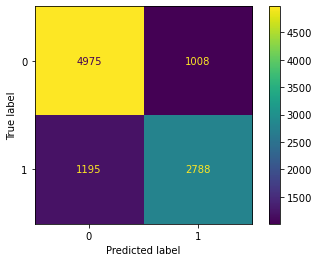

In [11]:
threshold = .57
pred_probs = tuned_log.predict_proba(X_valid_tfidf)[:,1]
#probs of being 1(pos)
preds=[1 if i > threshold else 0 for i in pred_probs]
eval_func(y_valid, preds)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2998
           1       0.73      0.72      0.72      2002

    accuracy                           0.78      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.78      0.78      0.78      5000



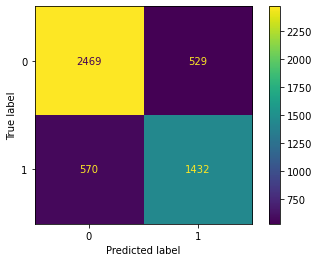

In [12]:
#Evaluate model on the test set
threshold = .57
test_pred_probs = tuned_log.predict_proba(X_test_tfidf)[:,1]
#probs of being 1(pos)
preds=[1 if i > threshold else 0 for i in test_pred_probs]
eval_func(y_test, preds)

In [13]:
#Pickle the model
pickle.dump(tuned_log, open('tuned_log_model.sav', 'wb'))


## Limitations and Moving Forward
-The validation and test data were imbalanced, and so it is not surprising that the model performed a little better on the majority class.  
-As I verified when manually labeling some of the Steelers tweets, some of the tweets contained sarcasm, which is difficult for the algorithm to learn. 
-Also, at least when labeling the Steelers tweets, I labelled any of the tweets as positive if they were neutral/purely factual. It would have been better to include a third class for purely neutral tweets, but the kaggle data set did not contain any actual neutrally labelled tweets. 
-Also, I tried to make the training data as representative as possible, both by using Twitter data (so the algorithm could become accustomed to the lingo/turns of phrase) and by supplementing with some labelled Steelers tweets. But it remains possible that the Steelers tweets contain football peculiarities not picked up by the machine. 
-As always, further text cleaning/preprocessing and tuning of the model is possible. In particular, I would have liked to see how the algorithms handled lemmatized data, but lemmatizing took too long.
-Future iterations of this project might, for example, use cloud computing to lemmatize the data and train a deep learning model for sentiment analysis. 